<font size="6.5">**Marginal Distribution Fitting by Resource**

<font size="3">This file takes raw transaction data as an input. We model the two resources, gas and calldata length, separately as independent entities. The output is two lists of generated transactions for the resources gas and calldata length. The goal of this file is to find various clusters in the raw dataset and model them with multiple joint distributions. Then, we can simulate transactions based on the estimated parameters of the cluster distributions.

    
<font size="3">The input file TxF22.csv is generated with simulator.py

In [9]:
#Import necessary packages and raw data file

import sys; sys.path.insert(0, '..')  # this adds the parent directory into the path, since we want simulations from the parent directory
from settings import DATA_PATH

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from sklearn.utils import shuffle
import random
from sklearn.linear_model import LinearRegression
import seaborn as sns
from collections import Counter 

file='transactionDataNew.csv'
data=pd.read_csv(str(DATA_PATH / file)) 


<font size="5">**Data Partitioning and Cleaning**
    
<font size="3">We split the data into training and test sets so that we can fit the distributions on the training data and evaluate fitment on the test data. To fit, we first remove the lower gas limit values (gas of 21000). In the transaction generation cell, we include these by modeling this value at the proportion that it appears in the dataset. 

In [10]:
TxGas=list(data['executionGas']) #gas used per Tx
TxCallData=list(data['callDataUsage'])

lowerLimitGas=21000 #drop extreme low Tx values for 
proportionGasLowerLimit=(np.size([x for x in TxGas if x == lowerLimitGas])/np.size(TxGas))
#print(round(100*proportionGasLowerLimit,3), '% of dataset dropped when truncating gas used equal to lower limit of',lowerLimitGas )

#Now randomly sample x and 1-x % of Tx to create test and training sets
np.random.seed(10)
(TxGas,TxCallData) = shuffle(TxGas,TxCallData) 
df=pd.DataFrame({'TxGas':TxGas,'TxCallData':TxCallData})
TxGas=[x for x in TxGas if x != lowerLimitGas] #drop all equal to lower limit
testSize=20 # % of Txs that will make up test set
TxGasTest=TxGas[0:round(len(TxGas)*testSize/100)]
TxGasTrain=TxGas[round(len(TxGas)*testSize/100):]

TxCallDataTest=TxCallData[0:round(len(TxCallData)*testSize/100)]
TxCallDataTrain=TxCallData[round(len(TxCallData)*testSize/100):]


<font size="5">**Gas Marginal Distributions Evaluated Against Known Distributions**
    
<font size="3">Our goal here is to evaluate which distribution models the gas values best (after omitting the lower gas limit of 21000). Evaluation is done by comparing empirical CDFs to the known distributions using Kolmogorov-Smirnov tests. 

<font size="3">(see https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).

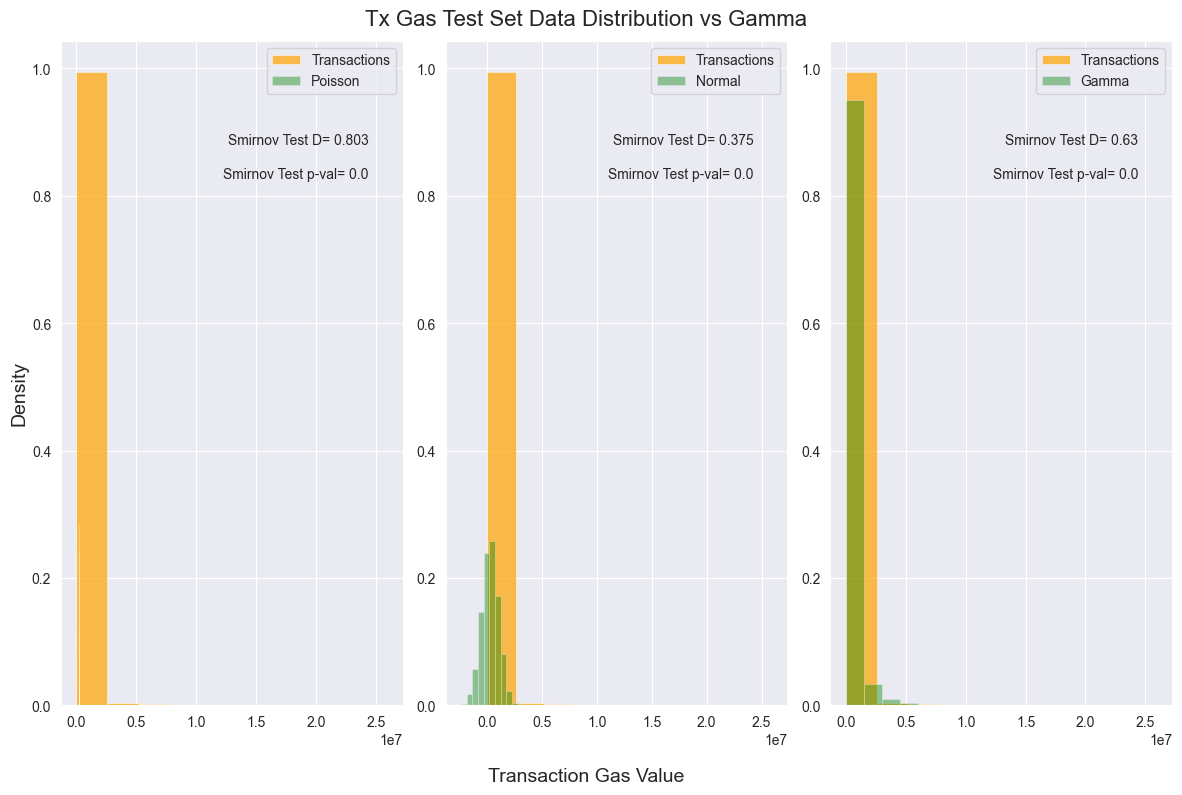

In [11]:
#####  This block fits gas to poisson/normal/gamma, runs K-S tests, and plots histograms  #####

numRVs=np.size(TxGasTrain)
poissGas=stats.poisson.rvs(np.mean(TxGasTrain),size=numRVs) #generate poisson points using estimated lambda from Tx data
norGas=np.random.normal(np.mean(TxGasTrain),np.var(TxGasTrain)**0.5,numRVs)  #generate poisson points using estimated lambda from Tx data

#MoM estimation of gamma distr:
aGas=(np.mean(TxGasTrain))**2/np.var(TxGasTrain)
betaGas=(np.mean(TxGasTrain))/np.var(TxGasTrain)
gamGas=stats.gamma.rvs(aGas, scale=1/betaGas,size=numRVs)

def ks_plot(data_desc,resource_desc, data, transaction_data,ax):
    binNumTxGas=1000
    binNumDistr=100
    ax.hist(transaction_data,alpha=0.7,label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(transaction_data)) / len(transaction_data) )
    fig.tight_layout(pad=1)
    fig.supxlabel('Transaction {} Value'.format(resource_desc), fontsize=14,ha='center')
    fig.supylabel('Density', fontsize=14)
    fig.suptitle('Tx {} Test Set Data Distribution vs {}'.format(resource_desc,data_desc), fontsize=16,ha='center')
    ax.hist(data,label=data_desc, alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(data)) / len(data) )
    KSBootstrapNum=1000
    #here add in bootstrapped KS test stat and pval? then plot. 
    ax.annotate('Smirnov Test D= ' + str(round(stats.kstest(transaction_data, data)[0],3)),xy = (.9, .85),xycoords='axes fraction',ha='right',va="center",fontsize=10)
    ax.annotate('Smirnov Test p-val= ' + str(round(stats.kstest(transaction_data, data)[1],5)),xy = (.9, .8),xycoords='axes fraction',ha='right',va="center",fontsize=10)
    ax.legend(fontsize=10)
    

fig, ax = plt.subplots(1,3,figsize=(12,8))
ks_plot("Poisson","Gas", poissGas,TxGasTest,ax=ax[0])  
ks_plot("Normal","Gas",  norGas,  TxGasTest,ax=ax[1])
ks_plot("Gamma","Gas",   gamGas,  TxGasTest,ax=ax[2])


<font size="5">**Call Data Marginal Distributions Evaluated Against Known Distributions**

<font size="3">Here, we evaluate which distribution models the call data length values best. Evaluation is done by comparing empirical CDFs to the known distributions using Kolmogorov-Smirnov tests.

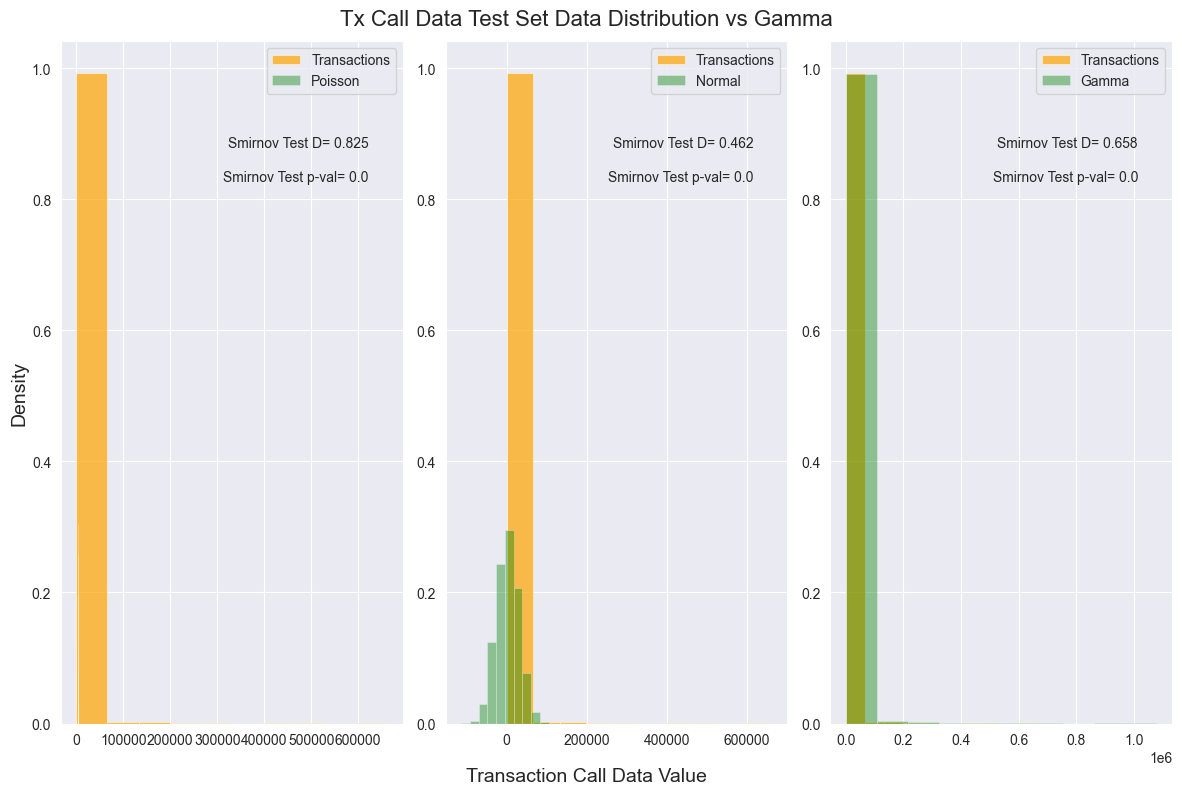

In [12]:
numRVs=np.size(TxCallDataTrain)
poissCallData=stats.poisson.rvs(np.mean(TxCallDataTrain),size=numRVs) #generate poisson points using estimated lambda from Tx data
norCallData=np.random.normal(np.mean(TxCallDataTrain),np.var(TxCallDataTrain)**0.5,numRVs)  #generate poisson points using estimated lambda from Tx data

#MoM estimation of gamma distr:
aCallData=(np.mean(TxCallDataTrain))**2/np.var(TxCallDataTrain)
betaCallData=(np.mean(TxCallDataTrain))/np.var(TxCallDataTrain)
gamCallData=stats.gamma.rvs(aCallData, scale=1/betaCallData,size=numRVs)



fig, ax = plt.subplots(1,3,figsize=(12,8))
ks_plot("Poisson","Call Data", poissCallData,TxCallDataTest,ax=ax[0])  
ks_plot("Normal","Call Data",  norCallData,  TxCallDataTest,ax=ax[1])
ks_plot("Gamma","Call Data",   gamCallData,  TxCallDataTest,ax=ax[2])


<font size="5">**Transaction Generation Assuming Independence**

<font size="3">For both gas and call data, gamma distributions yield the lowest Kolmogorov-Smirnov test statistic. In the following cell, we assume that gas and call data are independent and generate two lists of their values.
    
<font size="3">We include the lower gas limit values (gas=21000) by modeling this value at the proportion that it appears in the dataset. These are done separately because they were omitted in the distribution fitting steps to obtain better fits.

In [13]:
#####  This block generates gas and call data from separate gamma distributions  #####

lenGenerated=5000
TxGasGenerated=[]
TxCallDataGenerated=[]
for i in range(lenGenerated):
    TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1))) #must change to break into if statement below to generate diff calldata distr when gas=21k           
    ran=random.uniform(0, 1)
    if ran<proportionGasLowerLimit:
        TxGasGenerated.append(lowerLimitGas)
    else: 
        TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    


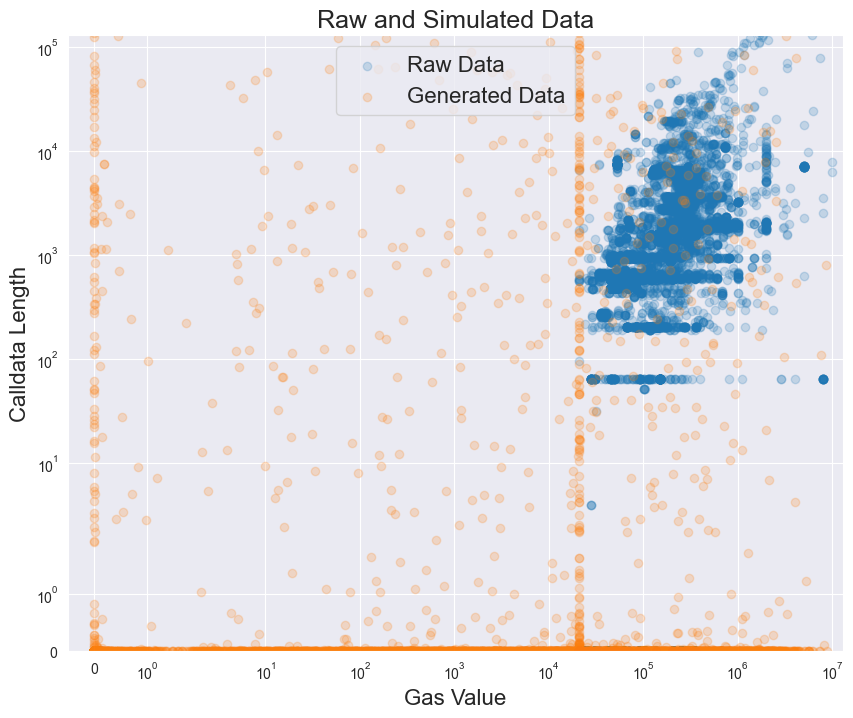

In [14]:
fig,ax=plt.subplots(figsize=(10,8))
ax.scatter(df['TxGas'],df['TxCallData'],alpha=.2,label='Raw Data')
ax.scatter(TxGasGenerated,TxCallDataGenerated,alpha=.2,label='Generated Data')
plt.title('Raw and Simulated Data', fontsize=18)
plt.xlabel('Gas Value', fontsize=16)
plt.ylabel('Calldata Length', fontsize=16)
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.legend(loc='upper left',title_fontsize=14)
ax.set_ylim([0, 130000])
ax.set_xlim([-.5, 13000000])

plt.legend(fontsize=16)
plt.show()


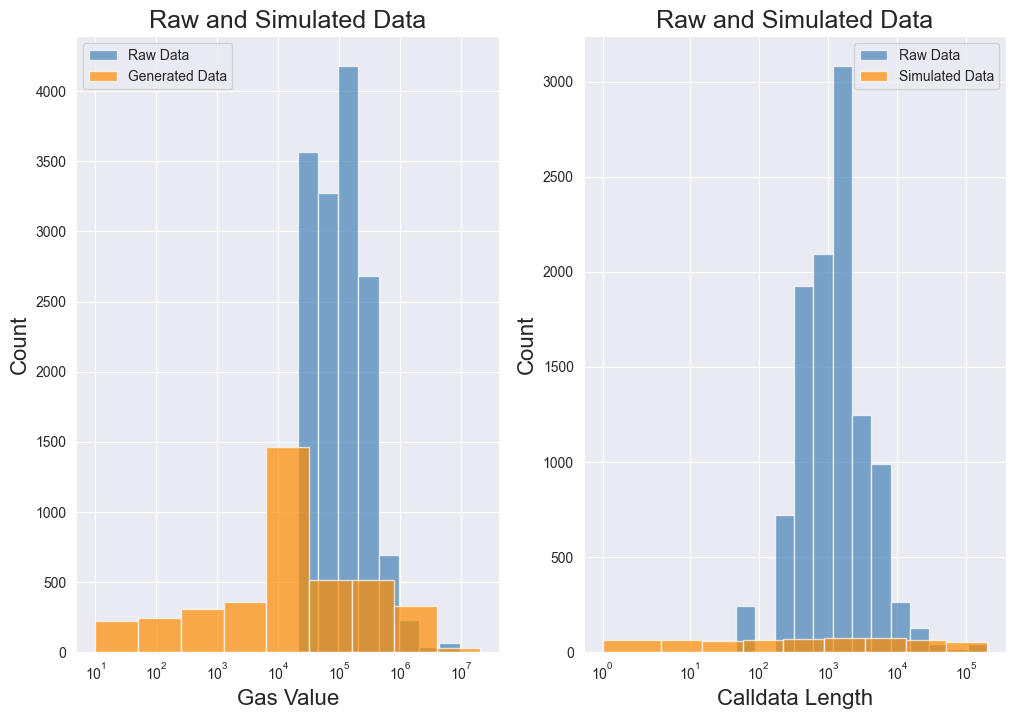

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].hist(df['TxGas'],label='Raw Data',alpha=.7,bins=np.logspace(start=np.log10(10), stop=np.log10(2e7), num=20),color='steelblue')
ax[0].hist(TxGasGenerated,label='Generated Data',alpha=.7,bins=np.logspace(start=np.log10(10), stop=np.log10(2e7), num=10),color='darkorange')
ax[0].set_title('Raw and Simulated Data', fontsize=18)
ax[0].set_xlabel('Gas Value', fontsize=16)
ax[0].set_ylabel('Count', fontsize=16)
ax[0].set_xscale('symlog')
ax[0].legend(loc='upper left',title_fontsize=14)



ax[1].hist(df['TxCallData'],label='Raw Data',alpha=.7,bins=np.logspace(start=0, stop=np.log10(2e5), num=20),color='steelblue')
ax[1].hist(TxCallDataGenerated,label='Simulated Data',alpha=.7,bins=np.logspace(start=0, stop=np.log10(2e5), num=10),color='darkorange')
ax[1].set_title('Raw and Simulated Data', fontsize=18)
ax[1].set_xlabel('Calldata Length', fontsize=16)
ax[1].set_ylabel('Count', fontsize=16)
ax[1].set_xscale('symlog')
ax[1].legend(loc='upper right',title_fontsize=14)

plt.show()






<font size="3">The plots above is what we expect to get if we were to generate gas and calldata separately and then randomly combine them as (x,y) points. This clearly gives a weird pattern that we wouldn't use for generation, so we can truncate these and replot. For this, we will restart completely with the raw data and create test and training sets. Since we are taking a naive approach, we will not model any specific calldata or gas values at the proportion they appear in the dataset like we did above for 21k gas.

In [16]:
TxGas=list(data['executionGas']) #gas used per Tx
TxCallData=list(data['callDataUsage'])

#Now randomly sample x and 1-x % of Tx to create test and training sets
np.random.seed(10)
(TxGas,TxCallData) = shuffle(TxGas,TxCallData) 
df=pd.DataFrame({'TxGas':TxGas,'TxCallData':TxCallData})
testSize=20 # % of Txs that will make up test set
TxGasTest=TxGas[0:round(len(TxGas)*testSize/100)]
TxGasTrain=TxGas[round(len(TxGas)*testSize/100):]

TxCallDataTest=TxCallData[0:round(len(TxCallData)*testSize/100)]
TxCallDataTrain=TxCallData[round(len(TxCallData)*testSize/100):]

dfTrain=pd.DataFrame({'TxGas':TxGasTrain,'TxCallData':TxCallDataTrain})
dfTest=pd.DataFrame({'TxGas':TxGasTest,'TxCallData':TxCallDataTest})



In [17]:
numRVs=np.size(TxGasTrain)
locGas=21000 #location parameter
#MoM estimation of Gas gamma distr:
aGas=(np.mean(TxGasTrain))**2/np.var(TxGasTrain)
betaGas=(np.mean(TxGasTrain))/np.var(TxGasTrain)
#gamGas=stats.gamma.rvs(aGas, scale=1/betaGas,size=numRVs,loc=locGas)

locCD=0 #location parameter
#MoM estimation of CD gamma distr:
aCallData=(np.mean(TxCallDataTrain))**2/np.var(TxCallDataTrain)
betaCallData=(np.mean(TxCallDataTrain))/np.var(TxCallDataTrain)
#gamCallData=stats.gamma.rvs(aCallData, scale=1/betaCallData,size=numRVs,loc=locCD)




In [18]:
lenGenerated=500
TxGasGenerated=[]
TxCallDataGenerated=[]
for i in range(lenGenerated):
    TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1,loc=locCD))) #must change to break into if statement below to generate diff calldata distr when gas=21k           
    TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1,loc=locGas)))


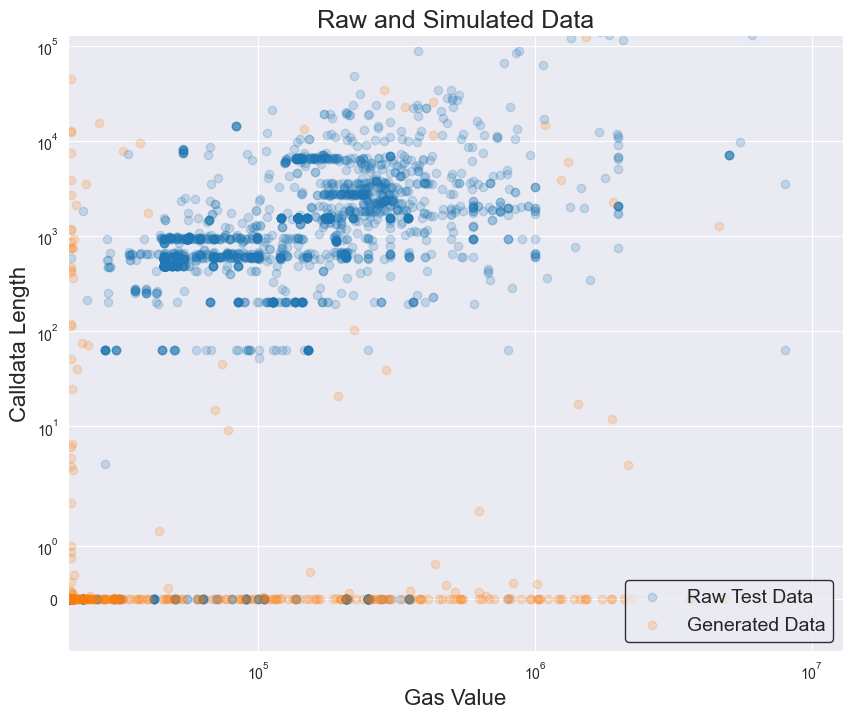

In [19]:
fig,ax=plt.subplots(figsize=(10,8))
ax.scatter(dfTest['TxGas'],dfTest['TxCallData'],alpha=.2,label='Raw Test Data')
ax.scatter(TxGasGenerated,TxCallDataGenerated,alpha=.2,label='Generated Data')
plt.title('Raw and Simulated Data', fontsize=18)
plt.xlabel('Gas Value', fontsize=16)
plt.ylabel('Calldata Length', fontsize=16)
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.legend(loc='lower right',fontsize=14,edgecolor='k')
ax.set_ylim([-1, 130000])
ax.set_xlim([20500, 13000000])

plt.show()


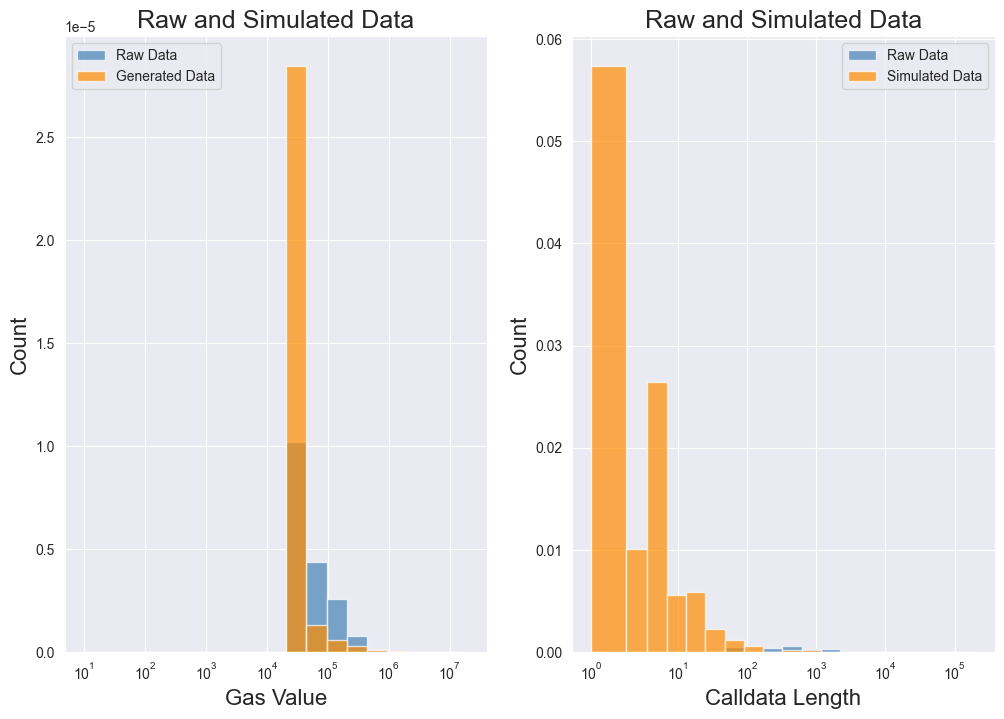

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].hist(df['TxGas'],label='Raw Data',alpha=.7,bins=np.logspace(start=np.log10(10), stop=np.log10(2e7), num=20),color='steelblue',density=True)
ax[0].hist(TxGasGenerated,label='Generated Data',alpha=.7,bins=np.logspace(start=np.log10(10), stop=np.log10(2e7), num=20),color='darkorange',density=True)
ax[0].set_title('Raw and Simulated Data', fontsize=18)
ax[0].set_xlabel('Gas Value', fontsize=16)
ax[0].set_ylabel('Count', fontsize=16)
ax[0].set_xscale('symlog')
ax[0].legend(loc='upper left',title_fontsize=14)



ax[1].hist(df['TxCallData'],label='Raw Data',alpha=.7,bins=np.logspace(start=0, stop=np.log10(2e5), num=20),color='steelblue',density=True)
ax[1].hist(TxCallDataGenerated,label='Simulated Data',alpha=.7,bins=np.logspace(start=0, stop=np.log10(2e5), num=20),color='darkorange',density=True)
ax[1].set_title('Raw and Simulated Data', fontsize=18)
ax[1].set_xlabel('Calldata Length', fontsize=16)
ax[1].set_ylabel('Count', fontsize=16)
ax[1].set_xscale('symlog')
ax[1].legend(loc='upper right',title_fontsize=14)

plt.show()

